<a href="https://colab.research.google.com/github/perlacueto/Feeling_Analysis/blob/main/Clasificador_Sentimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Load Libraries and Variables:

- The path to the folders containing neural network models and preprocessing files must be adapted.
- Access to drive files must be granted.




In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 6.2 MB/s eta 0:00:00


In [4]:
!pip install pad_sequences

  Preparing metadata (setup.py) ... done
  Created wheel for pad_sequences: filename=pad_sequences-0.6.1-py3-none-any.whl size=10200 sha256=9de30f31e98f27dd59db603d5cdfc4c7cb1c7cd4215d3331c97d11ac3b02a703
  Stored in directory: /root/.cache/pip/wheels/48/9d/22/0a6305b87a9cc46ccc032060a041c3b59f39ac462f7358997e
Successfully built pad_sequences


In [5]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


In [6]:
from nltk.util import pad_sequence
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
#xgboost
# Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
#from nltk.stem import WordNetLemmatizer

# Word2vec
import gensim
from gensim.models import Word2Vec


# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

#plot
import seaborn
seaborn.set(style='whitegrid')

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [7]:
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
#from nltk.stem import WordNetLemmatizer

#Replace all non alphabets
from unidecode import unidecode

#For lematization
import spacy

In [8]:
DATASET_ENCODING = "ISO-8859-1"

SEQUENCE_LENGTH = 600

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.45, 0.65)

# EXPORT
KERAS_MODEL2 = "/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/model2.h5"
WORD2VEC_MODEL2 = "/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/model2.w2v"
TOKENIZER_MODEL2 = "/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/tokenizer2.pkl"
ENCODER_MODEL2 = "/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/encoder2.pkl"

#Preprocess
dic_emoji = '/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/dic_emoji.xlsx'
lematizador = '/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/extension_lematizador.txt'
extend_stop_words = '/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/extension_stopwords.txt'

## Load models


In [9]:
w2v_model = Word2Vec.load(WORD2VEC_MODEL2)

In [10]:
file = open(ENCODER_MODEL2,'rb')
file.seek(0)
tokenizer = pickle.load(file)
file.close()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
with open(TOKENIZER_MODEL2, 'rb') as handle:
    tokenizer = pickle.load(handle)
tokenizer

: <keras_preprocessing.text.Tokenizer at ...>

In [35]:
model = load_model(KERAS_MODEL2)

In [12]:
def decode_sentiment(score, include_neutral):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [13]:
def predict(text, include_neutral= False):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

## Charge preprocessing tools


In [14]:
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = stopwords.words("spanish")
stemmer = SnowballStemmer("spanish")#extrae la raíz de una palabra
!spacy download es
lematiza = spacy.load("es_core_news_sm")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


⚠ As of spaCy v3.0, shortcuts like 'es' are deprecated. Please use the
full pipeline package name 'es_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 50.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [15]:
extend_stopword = []
with open(extend_stop_words, 'r')as copiar:
    aux_stop = list(copiar.readlines())
copiar.close()
for palabra in aux_stop:
    aux = re.sub("\n","",palabra)
    extend_stopword.append(aux)
#extend_stopword

In [16]:
stop_words.extend(extend_stopword)

In [17]:
elimina = ['no','estado','sin','como']
stop_words = [x for x in stop_words if x  not in elimina]

In [18]:
emojis = pd.read_excel(dic_emoji)
emojis.set_index('emoji',inplace=True)
emojis = emojis.to_dict()
emojis = emojis['equivale']
print(emojis)

{'😈': 'diablo', '😀': 'sonrisa', '😍': 'encantar', '😄': 'sonrisa', '😂': 'risa', '😉': 'guiño', '😊': 'sonrisa', '🤣': 'risa', '😘': 'beso', '🤡': 'payaso', '👻': 'fantasma', '😆': 'burla', '🥰': 'encantar', '😻': 'encantar', '😋': 'feliz', '😒': 'desagradar', '😓': 'desagradar', '😔': 'triste', '😖': 'triste', '😚': 'beso', '🏦': 'banco', '😜': 'burla', '😝': 'burla', '😞': 'triste', '😠': 'enojo', '😡': 'enojo', '😢': 'triste', '😣': 'frustracion', '😤': 'enojo', '😥': 'preocupacion', '😩': 'frustracion', '😪': 'triste', '😭': 'triste', '😫': 'frustracion', '😰': 'preocupacion', '😳': 'sonrojado', '😸': 'risa', '😹': 'risa', '😺': 'risa', '😿': 'triste', '🙅': 'bloqueo', '🙏': 'rezar', '❤': 'corazon', '👍': 'bien', '👎': 'mal', '👏': 'aplauso', '👪': 'familia', '👿': 'enojado', '💩': 'mierda', '💪': 'fuerza', '😐': 'neutral', '😑': 'serio', '😕': 'confundido', '😟': 'preocupacion', '😧': 'preocupacion', '🌞': 'sol', '🇻🇪': 'venezuela', '😨': 'miedo', '😱': 'miedo', ':)': 'sonrisa', '💜': 'corazon', '💝': 'regalo', '🚗': 'carro', '🚕': 'taxi',

In [19]:
with open(lematizador) as f:
    palabras = dict(i.rstrip().split(None, 1) for i in f)
print(len(palabras))

4698


In [20]:
#palabras.keys()

In [21]:
def preprocess(tweet, stem=False):

    # Create Lemmatizer and Stemmer.
    #wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    #sequencePattern   = r"(.)\1+"
    sequencePattern   = r"(.)\1\1+"
    #seqReplacePattern = r"\1\1"
    seqReplacePattern = r"\1"

    tweet = str(tweet).lower()

    # Replace all URls with 'URL'
    tweet = re.sub(urlPattern,' url',tweet)
    # Replace all emojis.
    for emoji in emojis.keys():
      tweet = tweet.replace(emoji, " emoji " + emojis[emoji]+" ")
    # Replace @USERNAME to 'USER'.
    tweet = re.sub(userPattern,'', tweet)
    # Replace all non alphabets.
    tweet = re.findall(r'[a-z]\w+', tweet)
    tweet = " ".join(tweet)
    tweet = unidecode(tweet)
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    #Lematiza
    tweet = lematiza(tweet)
    lemmas = [tok.lemma_.lower() for tok in tweet]


    tokens = []
    for token in lemmas:
          # Checking if the word is a stopword.
          if token not in stop_words:
            for palabra in palabras.keys():
              tok = token.replace(palabra, palabras[palabra])
            #cheching if word has more than one letter
            if len(tok)>1:
              if stem:
                tokens.append(stemmer.stem(tok))
              else:
                if tok not in stop_words:
                  tokens.append(tok)
    return " ".join(tokens)



In [22]:
def Cambiar_pagina(x):
    x = x.lower()
    x = x.replace('paginar','pagina')
    return x

In [31]:
def agregar_columnas(comentarios): # add columns
  comentarios = comentarios.assign(text_process=np.nan) #para texto lematizado
  comentarios = comentarios.assign(new_target=np.nan) #para clasificación
  comentarios = comentarios.assign(score=np.nan) #para score
  comentarios.head()
  return(comentarios)

In [32]:
def procesar_texto(comentarios): # process text
  comentarios.text_process = comentarios.text.apply(lambda x: preprocess(str(x)))
  return(comentarios)

In [33]:
def clasificar_texto(comentarios, include_neutral): #classify text with charge model and put score and label
  comentarios.score = comentarios.text_process.apply(lambda x: predict(x,include_neutral)['score'])
  comentarios.new_target = comentarios.text_process.apply(lambda x: predict(x,include_neutral)['label'])
  comentarios.head()
  return comentarios

In [29]:
def agrega_procesa_clasifica(comentarios,include_neutral):# unify process
  comentarios = agregar_columnas(comentarios)
  comentarios = procesar_texto(comentarios)
  comentarios = clasificar_texto(comentarios,include_neutral)
  return comentarios

## Individual comment proof

In [26]:
preprocess('ellos tienen buenos productos')#translated: 'they have good products'

'tener buen producto'

In [36]:
predict(preprocess('ellos tienen buenos productos'),)

1/1 [==============================] - 1s 697ms/step


<ipython-input-13-419ea66c994d>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'POSITIVE',
 'score': 0.636762261390686,
 'elapsed_time': 0.7954540252685547}

## Process comments dataset
* Modify the table path: Adjust the path to the folder containing the text you want to classify.
* Choose the code cell type: Depending on whether it’s an Excel or .csv file, select the appropriate code cell.
* Set deadline dates: Define the time limits.
* Column requirement: The table must have a column named text, and the comments within that column will be classified.
* Select classification mode: Choose the classification method.


In [37]:
#Charge data with comments
#CSV
df = pd.read_csv('/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/Comentarios_banesco.csv')
df['date'] = df['date'].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2297 entries, 0 to 2296
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   Unnamed: 0             2297 non-null   int64              
 1   type                   2297 non-null   object             
 2   username               2297 non-null   object             
 3   text                   2297 non-null   object             
 4   date                   2297 non-null   datetime64[ns, UTC]
 5   likes                  2297 non-null   int64              
 6   post_url               2297 non-null   object             
 7   post_typename          0 non-null      float64            
 8   post_caption_hashtags  62 non-null     object             
 9   post_comments          62 non-null     float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(5)
memory usage: 179.6+ KB


In [38]:
# Limit time

fecha_desde = pd.to_datetime('2023-09-01 00:00:00', format='%Y-%m-%d %H:%M:%S').tz_localize('UTC')
fecha_hasta = pd.to_datetime('2023-09-30 23:59:59', format='%Y-%m-%d %H:%M:%S').tz_localize('UTC')
df = df.loc[(df['date'] >= fecha_desde) & (df['date'] <= fecha_hasta)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1032 entries, 10 to 2214
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   Unnamed: 0             1032 non-null   int64              
 1   type                   1032 non-null   object             
 2   username               1032 non-null   object             
 3   text                   1032 non-null   object             
 4   date                   1032 non-null   datetime64[ns, UTC]
 5   likes                  1032 non-null   int64              
 6   post_url               1032 non-null   object             
 7   post_typename          0 non-null      float64            
 8   post_caption_hashtags  14 non-null     object             
 9   post_comments          14 non-null     float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(5)
memory usage: 88.7+ KB


In [ ]:
#EXCEL
#df = pd.read_excel('/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/mercantil banco_twitterOct0623toAug1723.xlsx')
#print(df.info())
#fecha_desde = pd.to_datetime('2023-08-23 00:00:00', format='%Y-%m-%d %H:%M:%S')
#fecha_hasta = pd.to_datetime('2023-09-30 23:59:59', format='%Y-%m-%d %H:%M:%S')
#df = df.loc[(df['date'] >= fecha_desde) & (df['date'] <= fecha_hasta)]
#df.info()

The algorithm will add columns that contain sentiment classification: Target and Score, with a call to process and classify. You should specify the mode; if you don’t, it will default to binary classification:

+ True to include Neutral.
+ False to use only Positive/Negative.


In [39]:
df = agrega_procesa_clasifica(df, True) #Escribe el modo

1/1 [==============================] - 0s 90ms/step


<ipython-input-13-419ea66c994d>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


1/1 [==============================] - 0s 173ms/step


## Check final dataset

In [41]:
df[['text_process','new_target','score']].head()

,text_process,new_target,score
10,buen conflicto no comprender ser viveza ser pr...,NEGATIVE,0.114169
12,buen hacer pago no aparecer cuenta pasar,NEGATIVE,0.418119
14,acabar debitar transaccion,NEUTRAL,0.609614
16,buen pasar cuenta no poder hacer transaccion,NEGATIVE,0.269402
18,querer saber ser verdad banescir otorgar credito,POSITIVE,0.718736


Text(0.5, 1.0, 'Dataset labels distribuition')

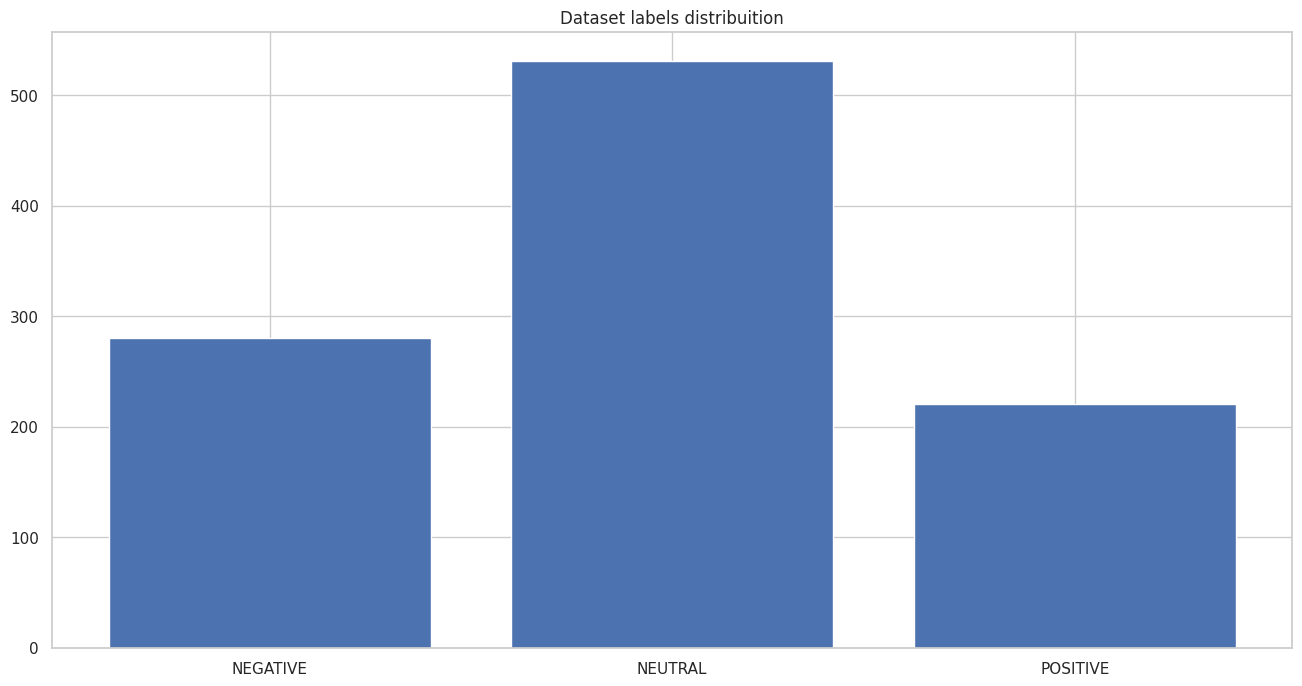

In [42]:
target_cnt = Counter(df.new_target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
df.to_excel("/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/Comment_process.xlsx")

In [ ]:
#df.to_csv("/content/drive/MyDrive/Mercantil/modelos_analisis_de_sentimiento/Insta_comment_process.csv")